In [1]:
import os.path as op
import numpy as np
from scipy import stats as stats
from scipy.stats import pearsonr
import os
import mne
import matplotlib.pyplot as plt
from mne.minimum_norm import make_inverse_operator, apply_inverse, source_band_induced_power, apply_inverse_epochs,compute_source_psd, compute_source_psd_epochs
from mne.datasets import fetch_fsaverage

from mne import spatial_src_adjacency
from mne.stats import spatio_temporal_cluster_test, summarize_clusters_stc
import pandas as pd

fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# The files live in:
subject = "fsaverage"
trans = "fsaverage"  # MNE has a built-in fsaverage transformation
src_fname = op.join(fs_dir, "bem", "fsaverage-ico-5-src.fif")

src = mne.read_source_spaces(src_fname)

0 files missing from root.txt in C:\Users\malann\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\malann\mne_data\MNE-fsaverage-data\fsaverage
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read


In [42]:
Control_list = ["PASC001", "PASC004", "PASC009", "PASC012", "PASC013", "PASC015", 
                "PASC020", "PASC022", "PASC025", "PASC030", "PASC037", "PASC040", 
                "PASC003", "PASC010", "PASC018", "PASC023", "PASC027", "PASC038", 
                "PASC005", "PASC011", "PASC014", "PASC019", "PASC024", "PASC034", 
                "PASC035", "PASC039", "PASC029", "PASC033", "PASC028", "PASC032",
                "PASC036", "PASC007", "PASC041"]

In [43]:
Control_list_LH = ["PASC001", "PASC013", "PASC014", "PASC018",
                   "PASC019", "PASC024", "PASC025", "PASC028",
                   "PASC029", "PASC030", "PASC033", "PASC037",
                   "PASC040"]
Control_list_RH = ["PASC003", "PASC005", "PASC009", "PASC010",
                   "PASC011", "PASC012", "PASC015", "PASC020",
                   "PASC022", "PASC023", "PASC027", "PASC034",
                   "PASC035", "PASC038", "PASC039"]

In [44]:
Control_list = ["PASC003"]

In [45]:
path_to_file = 'E:\Pain_Project_results\Behavioral data files\PASC_model_RH_data.xlsx'
    
df = pd.read_excel(path_to_file, sheet_name=Control_list[0])

pred_error = np.array(df['PE'])
prediction = np.array(df['prediction'])
pain_rating = np.array(df['PainRating'])

behavioral_data = [pred_error,prediction,pain_rating]
behavioral_name = ['Prediction Error','Prediction', 'Pain Rrating']

df.head()

,Pswitch/stay,choice,switched?,RT,prediction,outcome,PE,PainRating
0,0.500000,1,0,1.3996,0.500000,1,-0.500000,0.800618
1,0.125142,1,0,0.9034,0.253267,1,-0.253267,0.769706
2,0.050709,1,0,0.8364,0.128288,0,0.871712,0.000000
3,0.688872,1,0,0.6310,0.600851,1,-0.600851,0.714065
4,0.823754,2,1,0.5644,0.500000,0,0.500000,0.000000


In [17]:
subjects_dir = "E:/Freesurfer_Files"

labels = mne.read_labels_from_annot(
        "fsaverage", "aparc", "both", subjects_dir=subjects_dir
    )
labels = labels[:-1]

Reading labels from parcellation...
   read 35 labels from E:\Freesurfer_Files\fsaverage\label\lh.aparc.annot
   read 34 labels from E:\Freesurfer_Files\fsaverage\label\rh.aparc.annot


In [29]:
control_stcs = []
patient_PAF=[]
patient_PAF_power=[]
control_PAF=[]
control_PAF_power=[]
control_stc_all =[]
patient_stc_all = []
control_stcs_raw=[]
avg_stc_control1=0
avg_stc_control=0
fl, fh = 8,12

for sub in Control_list:
    if sub == 'PASC028':
        psd_dir = "E:/Control_Source_task_PSDs/"
    else:
        psd_dir = "E:/Morphed_Control_Source_task_PSDs/"

    subjects_dir = "E:/Freesurfer_Files"    
    
    
    for n in range(150):
        fname_stc= psd_dir+sub+'/ep_'+str(n)+"_dSPM"
        subject = 'fsaverage'    
    
        stc = mne.read_source_estimate(fname_stc, subject=subject)
        stc = stc.copy().crop(1, 50)

        stc_norm = stc.copy().sum()
        stc = 100 * stc/stc_norm.data
        
        avg_stc_control += stc
        control_stc_all.append(stc)
        
        stc = stc.copy().crop(fl, fh) 
        avg_stc_control1 += stc
        control_stcs_raw.append(stc)

        control_stcs.append(stc.data)
        source_time_max = (stc.get_peak()[1])
        source_vert_max = (stc.get_peak()[0])

        control_PAF.append(source_time_max)
        control_PAF_power.append(stc.data.max())
    
avg_stc_control=avg_stc_control/150

control_PAF = np.array(control_PAF)
control_PAF_power = np.array(control_PAF_power)

metrices = [control_PAF_power, control_PAF]
metrices_names= ["PAF Power", "PAF"]

PAF Power vs. Prediction
Correlation coef: -0.014566583400913317
P-value: 0.8595708832531492
PAF Power vs. Pain Rrating
Correlation coef: 0.022775483404680042
P-value: 0.7820534905423404
PAF vs. Prediction
Correlation coef: -0.008462340169103702
P-value: 0.9181400388409002
PAF vs. Pain Rrating
Correlation coef: 0.13376046465543545
P-value: 0.10270861777398618


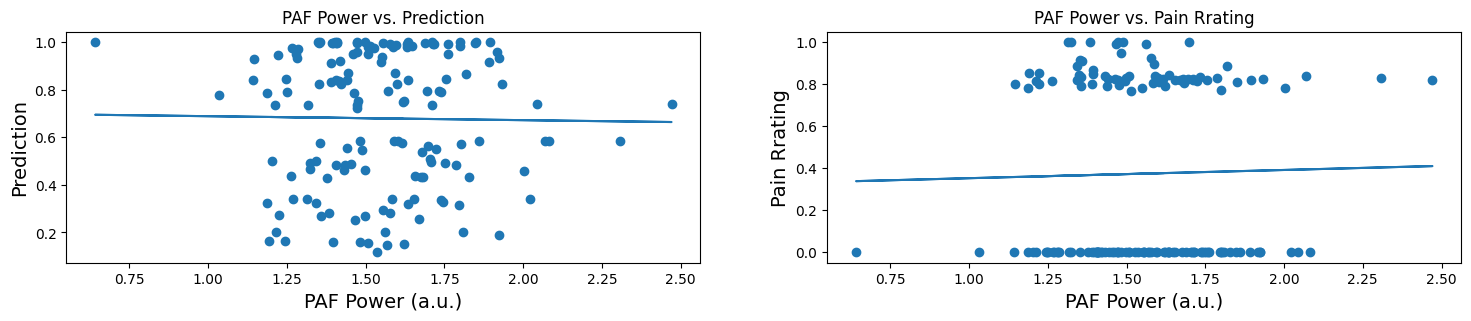

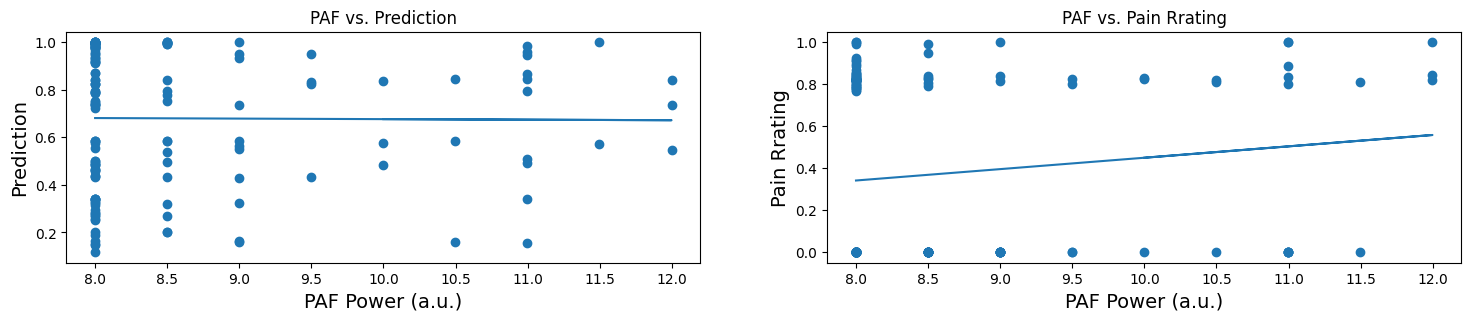

In [31]:
for j in range(len(metrices)):

    fig, ax = plt.subplots(1,len(behavioral_data), figsize=(18,3))
    
    for n in range(len(behavioral_data)):
        ax[n].scatter(metrices[j],list(behavioral_data[n]))
        ax[n].set_title(metrices_names[j] + " vs. " +behavioral_name[n])
        ax[n].set_xlabel("PAF Power (a.u.)",fontsize=14)
        ax[n].set_ylabel(behavioral_name[n],fontsize=14)

        #obtain m (slope) and b(intercept) of linear regression line
        m, b = np.polyfit(metrices[j],list(behavioral_data[n]), 1)
        #add linear regression line to scatterplot 
        ax[n].plot(metrices[j], m*metrices[j]+b)

        stats,p_val = pearsonr(metrices[j],list(behavioral_data[n]))
        print( metrices_names[j] + " vs. " +behavioral_name[n])
        print( f"Correlation coef: {stats}")
        print(f"P-value: {p_val}")

In [ ]:
brain = avg_stc_control1.plot(
    "fsaverage",
    hemi="both",
    views="dorsal",
    subjects_dir=subjects_dir,
    initial_time=0,
    background="w",

    time_label="temporal extent (ms)",
    clim=dict(kind="value", lims=[0, 2, 4]),
)
brain.add_annotation("aparc", borders=2)

Finding which areas are different

In [25]:
fl, fh=8,12

C_stcs_all = []
PAF_C_all = []
PAF_C_power_all=[]
for stc in control_stc_all:   
    C_stcs = []
    PAF_C=[]
    PAF_C_power=[]
    
    for lbl in labels:
        C_stcs.append(stc.in_label(lbl))
        PAF_C.append((stc.in_label(lbl).crop(fl, fh).get_peak()[1]))
        PAF_C_power.append(stc.in_label(lbl).crop(fl, fh).data.max())

    C_stcs_all.append(C_stcs)
    PAF_C_all.append(PAF_C)
    PAF_C_power_all.append(PAF_C_power)
    
C_stcs_all = np.array(C_stcs_all).T
PAF_C_all = np.array(PAF_C_all).T
PAF_C_power_all = np.array(PAF_C_power_all).T

In [26]:
behavioral_data = [pred_error,prediction,pain_rating]
behavioral_name = ['Prediction Error','Prediction', 'Pain Rrating']
for mm in range(len(behavioral_data)):
    
    pain_power_indx=[]
    for n in range(len(labels)):
        stats,p_val = pearsonr(PAF_C_power_all[n],list(behavioral_data[mm]))
        if p_val<0.05:
            pain_power_indx.append(n)


In [27]:
behavioral_data = [prediction,pain_rating]
behavioral_name = ['Prediction', 'Pain Rrating']

[9, 35, 39, 65]
Brain region: entorhinal-rh and Metrix : Prediction
0.18915896214428607
0.020432773315640033
Brain region: parahippocampal-rh and Metrix : Prediction
0.20075488554632842
0.013766533317670972
Brain region: parsorbitalis-rh and Metrix : Prediction
0.16911961432269834
0.03855702073033309
Brain region: temporalpole-rh and Metrix : Prediction
0.16728968476321882
0.040739179452571585
[]


ValueError: Number of columns must be a positive integer, not 0

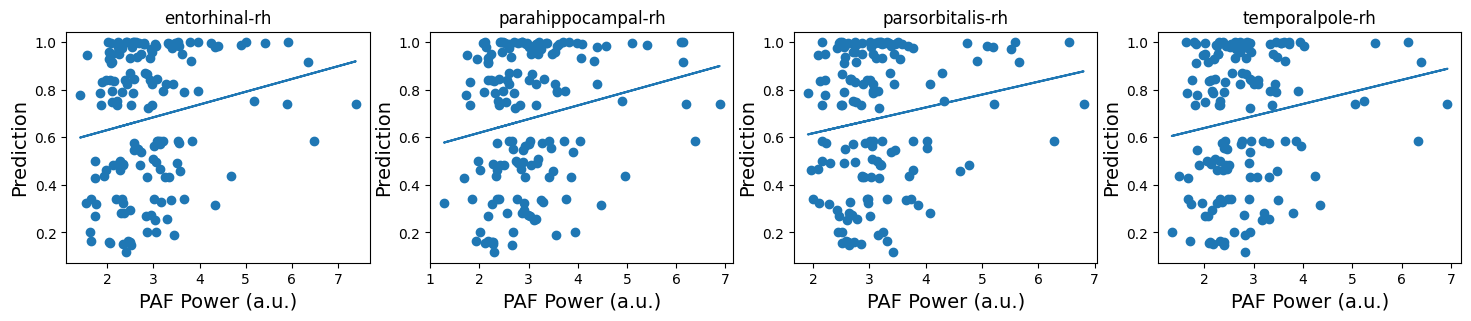

<Figure size 1800x300 with 0 Axes>

In [28]:
for mm in range(len(behavioral_data)):
    
    pain_power_indx=[]
    for n in range(len(labels)):
        stats,p_val = pearsonr(PAF_C_power_all[n],list(behavioral_data[mm]))
        if p_val<0.05:
            pain_power_indx.append(n)

    print(pain_power_indx)        
    fig, ax = plt.subplots(1,len(pain_power_indx), figsize=(18,3))

    for n in range(len(pain_power_indx)):
        ax[n].scatter(PAF_C_power_all[pain_power_indx[n]],list(behavioral_data[mm]))
        ax[n].set_title(labels[pain_power_indx[n]].name)
        ax[n].set_xlabel("PAF Power (a.u.)",fontsize=14)
        ax[n].set_ylabel(behavioral_name[mm],fontsize=14)

        print(f"Brain region: {labels[pain_power_indx[n]].name} and Metrix : {behavioral_name[mm]}")
        #obtain m (slope) and b(intercept) of linear regression line
        m, b = np.polyfit(PAF_C_power_all[pain_power_indx[n]],list(behavioral_data[mm]), 1)

        #add linear regression line to scatterplot 
        ax[n].plot(PAF_C_power_all[pain_power_indx[n]], m*PAF_C_power_all[pain_power_indx[n]]+b)

        stats,p_val = pearsonr(PAF_C_power_all[pain_power_indx[n]],list(behavioral_data[mm]))
        print(stats)
        print(p_val)

In [ ]:
pain_power_indx=[]
for n in range(len(labels)):
    stats,p_val = pearsonr(PAF_C_all[n],list(prediction))
    if p_val<0.05:
        pain_power_indx.append(n)

fig, ax = plt.subplots(1,len(pain_power_indx), figsize=(18,3))

if len(pain_power_indx)==1:

    plt.scatter(PAF_C_all[pain_power_indx],list(prediction))
    plt.title(labels[pain_power_indx[0]].name)
    plt.xlabel("PAF (Hz)",fontsize=14)
    plt.ylabel("prediction",fontsize=14)
    
    print(labels[pain_power_indx[0]].name)
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(PAF_C_all[pain_power_indx[0]],list(prediction), 1)

    #add linear regression line to scatterplot 
    plt.plot(PAF_C_all[pain_power_indx[0]], m*PAF_C_all[pain_power_indx[0]]+b)
    
    stats,p_val = pearsonr(PAF_C_all[pain_power_indx[0]],list(prediction))
    print(stats)
    print(p_val)
    
else:
    for n in range(len(pain_power_indx)):
        ax[n].scatter(PAF_C_all[pain_power_indx[n]],list(prediction))
        ax[n].set_title(labels[pain_power_indx[n]].name)
        ax[n].set_xlabel("PAF (Hz)",fontsize=14)
        ax[n].set_ylabel("prediction",fontsize=14)

        print(labels[pain_power_indx[n]].name)
        #obtain m (slope) and b(intercept) of linear regression line
        m, b = np.polyfit(PAF_C_all[pain_power_indx[n]],list(prediction), 1)

        #add linear regression line to scatterplot 
        ax[n].plot(PAF_C_all[pain_power_indx[n]], m*PAF_C_all[pain_power_indx[n]]+b)

        stats,p_val = pearsonr(PAF_C_all[pain_power_indx[n]],list(prediction))
        print(stats)
        print(p_val)

# Clinical Correlation with glm model

In [32]:
Control_list_LH = ["PASC001", "PASC013", "PASC014", "PASC018",
                   "PASC019", "PASC024", "PASC025", "PASC028",
                   "PASC029", "PASC030", "PASC033", "PASC037",
                   "PASC040"]
Control_list_RH = ["PASC003", "PASC005", "PASC009", "PASC010",
                   "PASC011", "PASC012", "PASC015", "PASC020",
                   "PASC022", "PASC023", "PASC027", "PASC034",
                   "PASC035", "PASC038", "PASC039"]

In [39]:
Control_list=[   "PASC001", "PASC018",
                   "PASC019", "PASC024", "PASC025", "PASC028",
                   "PASC029", "PASC030", "PASC033", "PASC037",
                   "PASC040"]

In [67]:
Control_list=[  "PASC010", "PASC013", "PASC018", "PASC023", 
                "PASC027", "PASC033", "PASC038", "PASC005", 
                "PASC011", "PASC014", "PASC019", "PASC024", 
                "PASC028"]

In [62]:
PAF_Power_all=[]
PAF_all=[]
fl, fh = 8,12

for sub in Control_list:

    if sub == 'PASC028':
        psd_dir = "E:/Control_Source_task_PSDs/"
    else:
        psd_dir = "E:/Morphed_Control_Source_task_PSDs/"
        
        
    
    subjects_dir = "E:/Freesurfer_Files"    

    #os.mkdir('E:/GLM_SPM/PASC_Task_gifti/'+sub)
    #os.mkdir('E:/GLM_SPM/PASC_Task_gifti/'+sub+"/PAF_Power")
    #os.mkdir('E:/GLM_SPM/PASC_Task_gifti/'+sub+"/PAF")
    
    avg_stc_control=0
    control_stc_all = []
    
    for n in range(150):
        fname_stc= psd_dir+sub+'/ep_'+str(n)+"_dSPM"
        subject = 'fsaverage'    
    
        stc = mne.read_source_estimate(fname_stc, subject=subject)
        stc = stc.copy().crop(1, 50)

        stc_norm = stc.copy().sum()
        stc = 100 * stc/stc_norm.data
        
      
        stc = stc.copy().crop(fl, fh) 

        PAF_Power = stc.data.max(axis=1)
        PAF_Power = PAF_Power.reshape([PAF_Power.shape[0],1])

        PAF = stc.times[stc.data.argmax(axis=1)]
        PAF = PAF.reshape([PAF.shape[0],1])
        
        PAF_Power = mne.SourceEstimate(PAF_Power,stc.vertices,tmin=stc.tmin, tstep=stc.tstep,subject="fsaverage")
        PAF = mne.SourceEstimate(PAF,stc.vertices,tmin=stc.tmin, tstep=stc.tstep,subject="fsaverage")
            
        PAF_Power_all.append(PAF_Power)
        PAF_all.append(PAF)
                
        PAF_Power.save('E:/GLM_SPM/PASC_Task_gifti/'+sub+'/PAF_Power/'+'/ep_'+str(n)+'_PAF_power',overwrite=True)
        PAF.save('E:/GLM_SPM/PASC_Task_gifti/'+sub+'/PAF/'+'/ep_'+str(n)+'_PAF',overwrite=True)


Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.

Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existin

Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to 

[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]
Writing STC to disk...
Overwriting existing file.
Overwriting existing file.
[done]


In [68]:
Control_list=[  "PASC010", "PASC013", "PASC018", "PASC023", 
                "PASC027", "PASC033", "PASC038", "PASC005", 
                "PASC011", "PASC014", "PASC019", "PASC024", 
                "PASC028"]

Alpha_Power_all=[]
Beta_Power_all=[]
Gamma_Power_all=[]

fl, fh = 8,12
fl1, fh1 = 13,30
fl2, fh2 = 31,100

for sub in Control_list:

    if sub == 'PASC028':
        psd_dir = "E:/Control_Source_task_PSDs/"
    else:
        psd_dir = "E:/Morphed_Control_Source_task_PSDs/"
        
        
    
    subjects_dir = "E:/Freesurfer_Files"    
    base_dir = 'E:/GLM_SPM/PASC_Task_gifti/'+sub
    os.mkdir(base_dir+"/Alpha_Power")
    os.mkdir(base_dir+"/Beta_Power")
    os.mkdir(base_dir+"/Gamma_Power")

    
    avg_stc_control=0
    control_stc_all = []
    
    for n in range(150):
        fname_stc= psd_dir+sub+'/ep_'+str(n)+"_dSPM"
        subject = 'fsaverage'    
    
        stc = mne.read_source_estimate(fname_stc, subject=subject)
        stc = stc.copy().crop(1, 100)

        stc_norm = stc.copy().sum()
        stc = 100 * stc/stc_norm.data
        alpha_stc = stc.copy().crop(fl, fh) 
        beta_stc = stc.copy().crop(fl1, fh1) 
        gamma_stc = stc.copy().crop(fl2, fh2) 

        Alpha_Power = alpha_stc.data.mean(axis=1)
        Alpha_Power = Alpha_Power.reshape([Alpha_Power.shape[0],1])
        Alpha_Power = mne.SourceEstimate(Alpha_Power,alpha_stc.vertices,tmin=alpha_stc.tmin, tstep=alpha_stc.tstep,subject="fsaverage")
        Alpha_Power_all.append(Alpha_Power)
        Alpha_Power.save('E:/GLM_SPM/PASC_Task_gifti/'+sub+'/Alpha_Power/'+'/ep_'+str(n)+'_Alpha_power',overwrite=True)

        Beta_Power = beta_stc.data.mean(axis=1)
        Beta_Power = Beta_Power.reshape([Beta_Power.shape[0],1])
        Beta_Power = mne.SourceEstimate(Beta_Power,beta_stc.vertices,tmin=beta_stc.tmin, tstep=beta_stc.tstep,subject="fsaverage")
        Beta_Power_all.append(Beta_Power)
        Beta_Power.save('E:/GLM_SPM/PASC_Task_gifti/'+sub+'/Beta_Power/'+'/ep_'+str(n)+'_Beta_Power',overwrite=True)
        
        Gamma_Power = gamma_stc.data.mean(axis=1)
        Gamma_Power = Gamma_Power.reshape([Gamma_Power.shape[0],1])
        Gamma_Power = mne.SourceEstimate(Gamma_Power,gamma_stc.vertices,tmin=gamma_stc.tmin, tstep=gamma_stc.tstep,subject="fsaverage")
        Gamma_Power_all.append(Gamma_Power)
        Gamma_Power.save('E:/GLM_SPM/PASC_Task_gifti/'+sub+'/Gamma_Power/'+'/ep_'+str(n)+'_Gamma_Power',overwrite=True)

Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing ST

[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Writing STC to disk...
[done]
Wri

KeyboardInterrupt: 

In [63]:
len(PAF_Power_all)

150

In [72]:
fname_stc= 'E:\GLM_SPM\PASC_Task_gifti\PASC005\Alpha_Power\ep_0_Alpha_power-lh.stc'
stc = mne.read_source_estimate(fname_stc, subject=subject)


In [74]:
brain = stc.plot(
    "fsaverage",
    hemi="both",
    surface='pial',
    views="dorsal",
    subjects_dir=subjects_dir,
    initial_time=0,
    background="w",
    time_label="temporal extent (ms)",
    clim=dict(kind="value", lims=[0, 2, 4]),    
)
brain.add_annotation("aparc", borders=2)

In [ ]:
brain = PAF_all[87].plot(
    "fsaverage",
    hemi="both",
    surface='pial',
    views="dorsal",
    subjects_dir=subjects_dir,
    initial_time=0,
    background="w",
    time_label="temporal extent (ms)",
    clim=dict(kind="value", lims=[8, 10.5, 13]),    
)
brain.add_annotation("aparc", borders=2)